In [1173]:
# when including all soc (also not possible outliers > 100%:
#when filter for soc < 15 (only 4400 rows):
#both rf and light gbm at 45/46 r2 and rsme at ~2
#light gbm best performance with hyperparameter tuning:
#LightGBM Mean Squared Error (MSE): 1.9379188619634926
#LightGBM R^2 Score: 0.4762943514955047
#with sand and silt (final streamlit):
#LightGBM Mean Squared Error (MSE): 1.9781836032843005
#LightGBM R^2 Score: 0.46541315678753103

In [1174]:
import pandas as pd

# Import the CSV file into a DataFrame
df = pd.read_csv('/Users/maxsonntag/Documents/GitHub/SOC_predictor/data/feature_table_fixed.csv')  # Replace with the path to your CSV file


# Check for NaN values in the 'soc_in_percent' column
nan_count = df['soc_in_percent'].isna().sum()
print(f"SOC NaN counts: {nan_count}")
#Drop rows with NaNs in 'soc_in_percent'
df = df.dropna(subset=['soc_in_percent'])

# Move 'soc_in_percent' to the end of the DataFrame
columns = [col for col in df.columns if col != 'soc_in_percent']
df = df[columns + ['soc_in_percent']]

df.head()

SOC NaN counts: 21


,sample_date,lat,long,depth,elevation,NDVI_mean,NDVI_std,NDVI_trend,NDMI_mean,NDMI_std,...,BSI_trend,SOCI_mean,SOCI_std,SOCI_trend,land_cover_type,main_vegetation_type,sand,silt,clay,soc_in_percent
0,2018-07-18,34.69405,32.58075,0-20 cm,26,0.224599,0.040016,0.001359,0.095654,0.062487,...,-0.001405,0.000074,0.000007,2.023169e-07,Cropland,Oranges,48.875480,30.798668,20.325851,1.64
1,2018-04-16,34.72196,32.54419,0-20 cm,64,0.182113,0.091374,-0.001681,0.056626,0.114328,...,0.000395,0.000071,0.000009,-1.974404e-07,Cropland,Mix of cereals,44.333870,34.784683,20.881447,2.86
2,2018-07-30,34.74907,32.73422,0-20 cm,524,0.180001,0.039758,0.001124,0.024138,0.049634,...,-0.000053,0.000069,0.000006,-8.508878e-08,Cropland,Permanent industrial crops,48.091133,27.219765,24.689102,3.92
3,2018-08-05,34.75969,32.69219,0-20 cm,573,0.164987,0.026108,0.000281,0.020724,0.055104,...,-0.001324,0.000061,0.000007,-1.737622e-07,Cropland,Permanent industrial crops,43.097702,31.428072,25.474228,0.99
4,2018-06-15,34.78786,33.31504,0-20 cm,165,0.165559,0.073905,0.002379,0.020415,0.086268,...,-0.001203,0.000065,0.000011,2.595119e-07,Cropland,Mix of cereals,41.502327,25.536749,32.960922,2.35


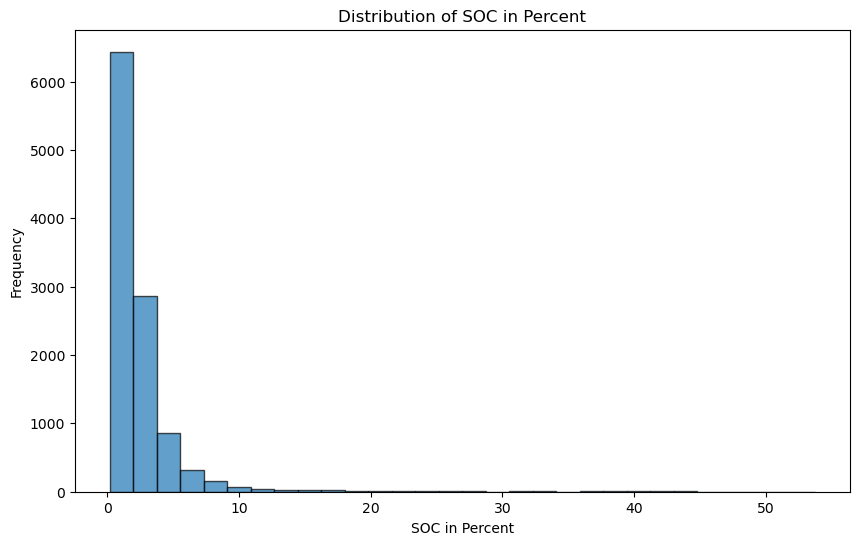

In [1175]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.hist(df['soc_in_percent'], bins=30, edgecolor='k', alpha=0.7)
plt.xlabel('SOC in Percent')
plt.ylabel('Frequency')
plt.title('Distribution of SOC in Percent')

# Save the figure
plt.savefig('soc_in_percent_distribution.png', format='png')
plt.show()


In [1176]:
# Filter out SOC values above 100%
df = df[df['soc_in_percent'] < 100]

# List all SOC values above 50% in the filtered data
soc_above_50 = df[df['soc_in_percent'] > 0]

# Display the rows with SOC > 50%
print(soc_above_50)

#also done for 15 30 and 50%
# > 0%: 10910 rows
# > 15%: 134 rows
# > 30%: 49 rows
# > 50%: 4 rows

df = df[df['soc_in_percent'] < 15]

      sample_date       lat      long    depth  elevation  NDVI_mean  \
0      2018-07-18  34.69405  32.58075  0-20 cm         26   0.224599   
1      2018-04-16  34.72196  32.54419  0-20 cm         64   0.182113   
2      2018-07-30  34.74907  32.73422  0-20 cm        524   0.180001   
3      2018-08-05  34.75969  32.69219  0-20 cm        573   0.164987   
4      2018-06-15  34.78786  33.31504  0-20 cm        165   0.165559   
...           ...       ...       ...      ...        ...        ...   
10926  2018-08-03  64.81254  25.69551  0-20 cm         22   0.163700   
10927  2018-08-04  64.82691  25.35893  0-20 cm         -5   0.172748   
10928  2018-07-04  65.88612  24.28498  0-20 cm        -17   0.190639   
10929  2018-05-29  66.09653  29.49666  0-20 cm        278   0.168082   
10930  2018-08-10  66.39432  24.38920  0-20 cm         45   0.155932   

       NDVI_std  NDVI_trend  NDMI_mean  NDMI_std  ...  BSI_trend  SOCI_mean  \
0      0.040016    0.001359   0.095654  0.062487  ...  -

In [1177]:
# Calculate Pearson and Spearman correlations with the target column
# Dropping non-numeric columns for correlation if any exist
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate Pearson correlation with soc_in_percent
pearson_corr = numeric_df.corr(method='pearson')['soc_in_percent'].drop('soc_in_percent')

# Calculate Spearman correlation with soc_in_percent
spearman_corr = numeric_df.corr(method='spearman')['soc_in_percent'].drop('soc_in_percent')

# Combine Pearson and Spearman correlations into a single DataFrame
correlations = pd.DataFrame({
    'Pearson': pearson_corr,
    'Spearman': spearman_corr
})

# Display the correlations
print("Pearson and Spearman correlations with 'soc_in_percent':")
print(correlations)


Pearson and Spearman correlations with 'soc_in_percent':
             Pearson  Spearman
lat         0.201028  0.235233
long       -0.022386  0.066861
elevation   0.077304 -0.043710
NDVI_mean   0.360909  0.425499
NDVI_std    0.173419  0.242345
NDVI_trend  0.115097  0.130664
NDMI_mean   0.410258  0.475542
NDMI_std   -0.083285 -0.062290
NDMI_trend  0.006628  0.015425
BSI_mean   -0.422085 -0.505583
BSI_std    -0.191688 -0.151627
BSI_trend  -0.042046 -0.053870
SOCI_mean   0.226961  0.330839
SOCI_std    0.144092  0.307749
SOCI_trend  0.109243  0.111362
sand        0.004468  0.112191
silt        0.004468  0.158126
clay        0.004468 -0.121574


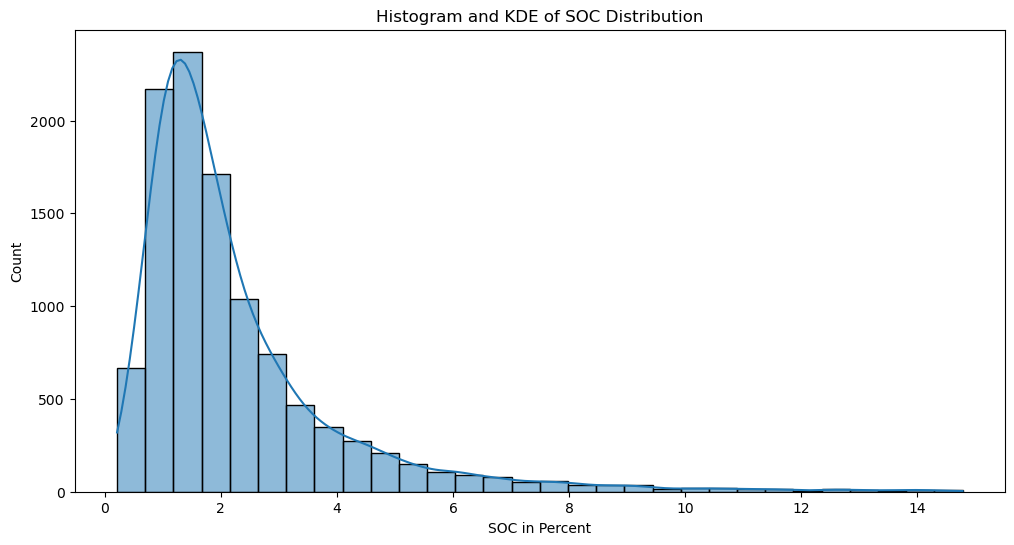

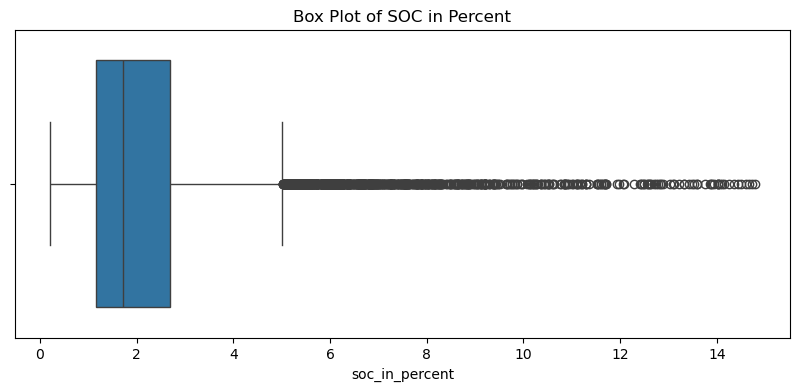

In [1178]:
import matplotlib.pyplot as plt
import seaborn as sns

# Histogram with KDE
plt.figure(figsize=(12, 6))
sns.histplot(df['soc_in_percent'], kde=True, bins=30)
plt.title('Histogram and KDE of SOC Distribution')
plt.xlabel('SOC in Percent')
plt.show()

# Box plot for outliers
plt.figure(figsize=(10, 4))
sns.boxplot(x=df['soc_in_percent'])
plt.title('Box Plot of SOC in Percent')
plt.show()


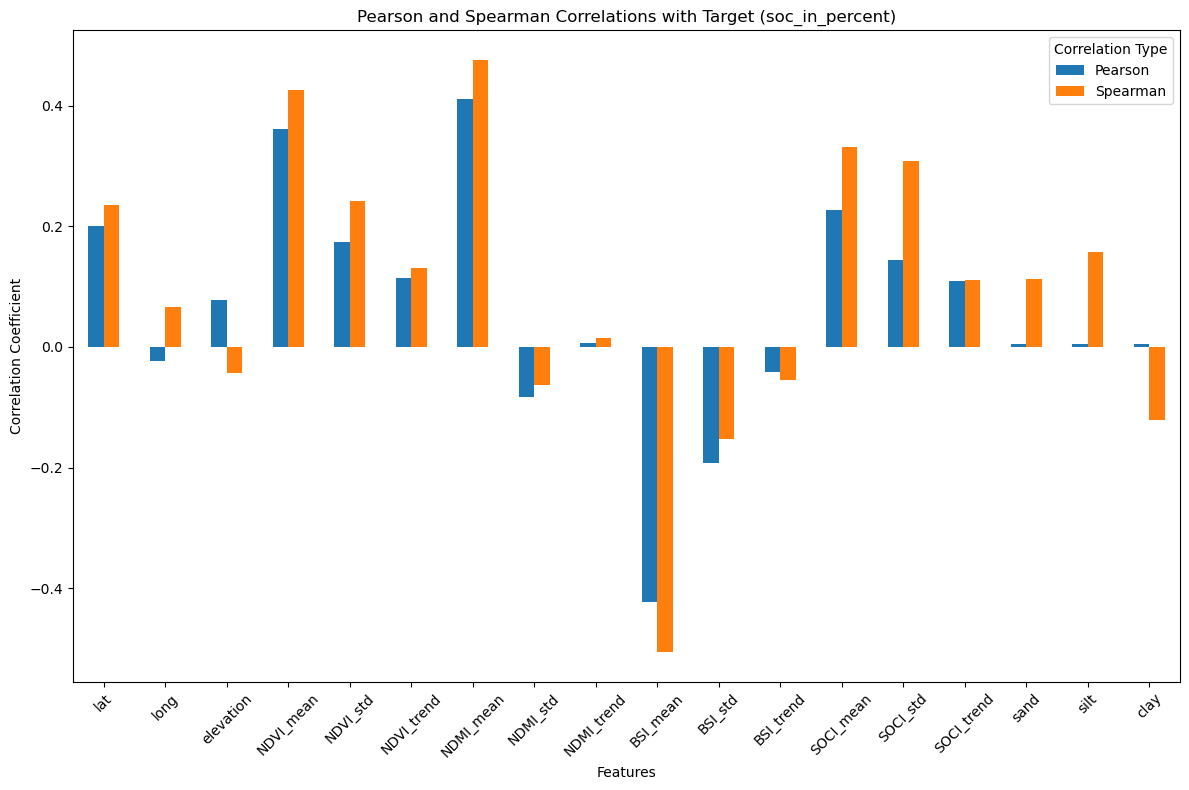

In [1179]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'correlations' DataFrame with Pearson and Spearman correlations
# Calculate correlations as in previous example code
correlations.plot(kind='bar', figsize=(12, 8))
plt.title('Pearson and Spearman Correlations with Target (soc_in_percent)')
plt.ylabel('Correlation Coefficient')
plt.xlabel('Features')
plt.xticks(rotation=45)
plt.legend(title="Correlation Type")
plt.tight_layout()
plt.show()


Pearson and Spearman correlations with 'soc_in_percent':
             Pearson  Spearman
lat         0.201028  0.235233
long       -0.022386  0.066861
elevation   0.077304 -0.043710
NDVI_mean   0.360909  0.425499
NDVI_std    0.173419  0.242345
NDVI_trend  0.115097  0.130664
NDMI_mean   0.410258  0.475542
NDMI_std   -0.083285 -0.062290
NDMI_trend  0.006628  0.015425
BSI_mean   -0.422085 -0.505583
BSI_std    -0.191688 -0.151627
BSI_trend  -0.042046 -0.053870
SOCI_mean   0.226961  0.330839
SOCI_std    0.144092  0.307749
SOCI_trend  0.109243  0.111362
sand        0.004468  0.112191
silt        0.004468  0.158126
clay        0.004468 -0.121574


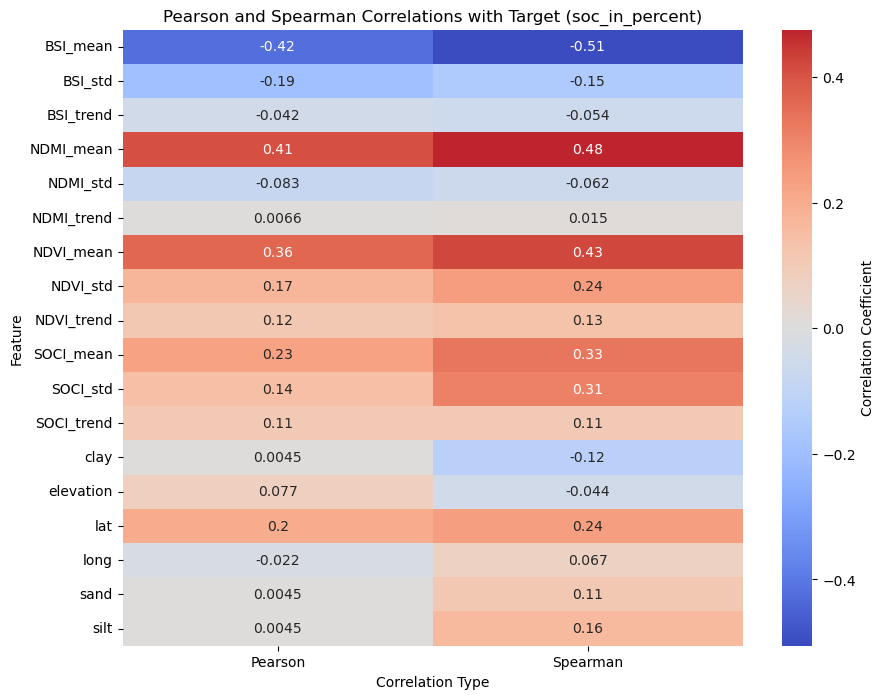

In [1180]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlations again, now including one-hot encoded columns
# Select only numeric columns, including float, int, and uint8 for binary encoded columns
numeric_df = df.select_dtypes(include=['float64', 'int64'])

# Calculate Pearson correlation with soc_in_percent
pearson_corr = numeric_df.corr(method='pearson')['soc_in_percent'].drop('soc_in_percent')

# Calculate Spearman correlation with soc_in_percent
spearman_corr = numeric_df.corr(method='spearman')['soc_in_percent'].drop('soc_in_percent')

# Combine Pearson and Spearman correlations into a single DataFrame
correlations = pd.DataFrame({
    'Pearson': pearson_corr,
    'Spearman': spearman_corr
})

# Display the correlations
print("Pearson and Spearman correlations with 'soc_in_percent':")
print(correlations)

# Assuming 'correlations' DataFrame with Pearson and Spearman correlations
# Convert to long format for easier plotting in heatmap
correlations_long = correlations.reset_index().melt(id_vars='index', var_name='Correlation Type', value_name='Correlation')
correlations_long.columns = ['Feature', 'Correlation Type', 'Correlation']

# Pivot the long format DataFrame to create a matrix for the heatmap
correlations_pivot = correlations_long.pivot(index='Feature', columns='Correlation Type', values='Correlation')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations_pivot, annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Pearson and Spearman Correlations with Target (soc_in_percent)')
plt.show()

In [1181]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [1182]:
df.drop(columns=['sample_date'], inplace=True)
df.drop(columns=['depth'], inplace=True)

In [1183]:
#df.land_cover_type.value_counts()
df = df[df['land_cover_type'] != 'Artificial land']

In [1184]:
#one hot encoding for land_cover_type:
# One-hot encode the 'land_cover_type' column after filtering
df = pd.get_dummies(df, columns=['land_cover_type'])

In [1185]:
df.main_vegetation_type.value_counts()

main_vegetation_type
Grassland without tree/shrub cover           2526
Common wheat                                 1550
Barley                                        974
Maize                                         851
Olive groves                                  446
Rape and turnip rape                          423
Sunflower                                     332
Temporary grassland                           311
Vineyards                                     291
Other bare soil                               276
Durum wheat                                   233
Oats                                          230
Grassland with sparse tree/shrub cover        221
Rye                                           219
Lucerne                                       196
Spontaneously re-vegetated surfaces           195
Dry pulses                                    169
Nuts trees                                    117
Sugar beet                                    112
Potatoes                     

In [1186]:
# Filter out categories with fewer than 10 occurrences
rare_categories = df['main_vegetation_type'].value_counts()
df = df[df['main_vegetation_type'].isin(rare_categories[rare_categories >= 10].index)]

In [1187]:
# combine frequency encoding & target encoding for the categorical feature with lots of different values
import numpy as np
freq_encoding = df['main_vegetation_type'].value_counts()
df['main_vegetation_type_freq_encoded'] = df['main_vegetation_type'].map(freq_encoding)

mean_encoding = df.groupby('main_vegetation_type')['soc_in_percent'].mean()
df['main_vegetation_type_target_encoded'] = df['main_vegetation_type'].map(mean_encoding)

# Save these mappings as .npy files
freq_encoding.to_dict()
np.save("main_vegetation_type_freq_encoding.npy", freq_encoding.to_dict())
np.save("main_vegetation_type_mean_encoding.npy", mean_encoding.to_dict())

# Drop original categorical columns after encoding
df = df.drop(columns=['main_vegetation_type'])

Pearson and Spearman correlations with 'soc_in_percent':
                                      Pearson  Spearman
lat                                  0.202369  0.236669
long                                -0.022617  0.067259
elevation                            0.074737 -0.045903
NDVI_mean                            0.361714  0.426413
NDVI_std                             0.173863  0.243684
NDVI_trend                           0.116810  0.131567
NDMI_mean                            0.410821  0.476622
NDMI_std                            -0.082658 -0.061162
NDMI_trend                           0.007165  0.016121
BSI_mean                            -0.422546 -0.506507
BSI_std                             -0.191464 -0.151015
BSI_trend                           -0.042762 -0.054367
SOCI_mean                            0.226567  0.330557
SOCI_std                             0.144072  0.308638
SOCI_trend                           0.109512  0.111578
sand                                 0.004476  

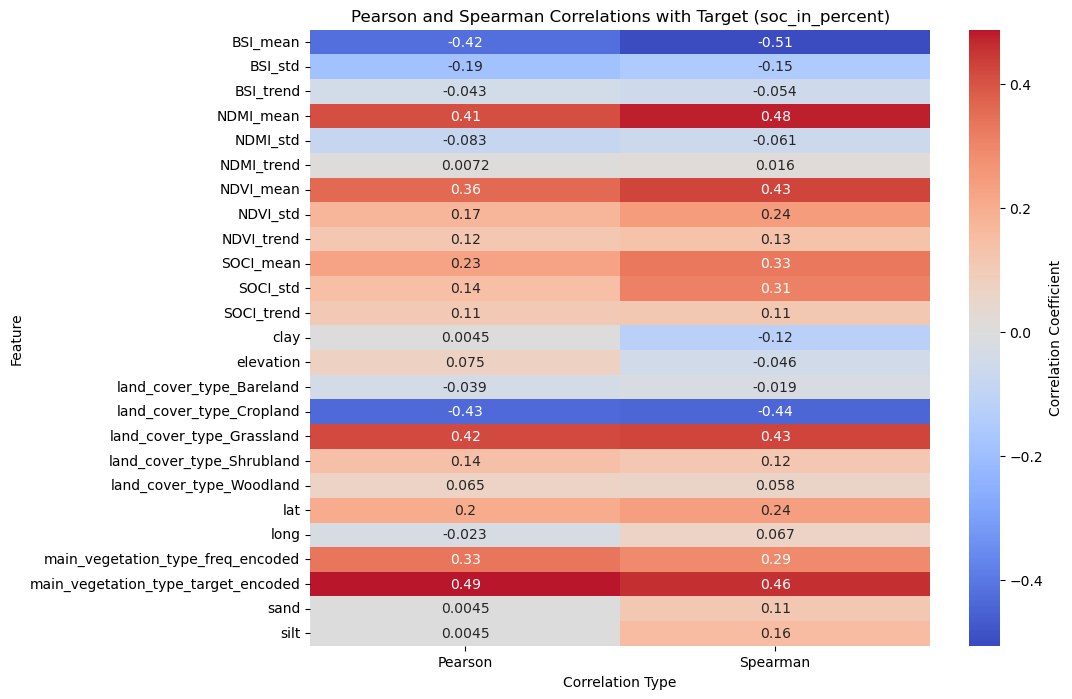

In [1188]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Calculate correlations again, now including one-hot encoded columns
# Select only numeric columns, including float, int, and uint8 for binary encoded columns
numeric_df = df.select_dtypes(include=['float64', 'int64', 'bool']) #to also include the one hot encoded feature

# Calculate Pearson correlation with soc_in_percent
pearson_corr = numeric_df.corr(method='pearson')['soc_in_percent'].drop('soc_in_percent')

# Calculate Spearman correlation with soc_in_percent
spearman_corr = numeric_df.corr(method='spearman')['soc_in_percent'].drop('soc_in_percent')

# Combine Pearson and Spearman correlations into a single DataFrame
correlations = pd.DataFrame({
    'Pearson': pearson_corr,
    'Spearman': spearman_corr
})

# Display the correlations
print("Pearson and Spearman correlations with 'soc_in_percent':")
print(correlations)

# Assuming 'correlations' DataFrame with Pearson and Spearman correlations
# Convert to long format for easier plotting in heatmap
correlations_long = correlations.reset_index().melt(id_vars='index', var_name='Correlation Type', value_name='Correlation')
correlations_long.columns = ['Feature', 'Correlation Type', 'Correlation']

# Pivot the long format DataFrame to create a matrix for the heatmap
correlations_pivot = correlations_long.pivot(index='Feature', columns='Correlation Type', values='Correlation')

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlations_pivot, annot=True, cmap='coolwarm', center=0, cbar_kws={'label': 'Correlation Coefficient'})
plt.title('Pearson and Spearman Correlations with Target (soc_in_percent)')
plt.savefig('correlations_with_target.png', format='png')
plt.show()

In [1189]:
#set up train and test (run until here, than go into the models)
#Separate Features and Target
X = df.drop(columns=['soc_in_percent'])  # Features
y = df['soc_in_percent']                 # Target

# Split Data into Training and Testing Sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [925]:
# Initialize and Train the Random Forest Model
# You can adjust the hyperparameters as needed
import time

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: Make Predictions on the Test Set
y_pred = model.predict(X_test)

# Step 6: Evaluate Model Performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

# Optional: Feature Importance
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importance_df)

# Measure end time
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

Mean Squared Error: 2.075338751341492
R^2 Score: 0.4391578264857817
Feature Importances:
                                Feature  Importance
24  main_vegetation_type_target_encoded    0.235181
0                                   lat    0.083728
2                             elevation    0.075499
1                                  long    0.072027
9                              BSI_mean    0.066664
16                                 silt    0.064925
6                             NDMI_mean    0.052170
12                            SOCI_mean    0.044709
15                                 sand    0.036264
3                             NDVI_mean    0.034834
5                            NDVI_trend    0.028570
17                                 clay    0.028547
10                              BSI_std    0.027562
4                              NDVI_std    0.026662
8                            NDMI_trend    0.026091
7                              NDMI_std    0.025682
11                         

In [377]:
# Convert boolean columns to integers
X = X.astype({col: 'int' for col in X.select_dtypes(include='bool').columns})

In [391]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import pandas as pd

# Add constant to include an intercept in VIF calculations
X_with_const = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_const.values, i + 1) for i in range(X.shape[1])]  # Skip intercept

# Display features with high VIF
print("Features with high VIF:")
print(vif_data[vif_data["VIF"] > 5])


Features with high VIF:
   Feature  VIF
15    sand  inf
16    silt  inf
17    clay  inf


/opt/anaconda3/lib/python3.12/site-packages/statsmodels/stats/outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [1207]:
#drop sand and clay as they have lower correlation with soc than silt:
#df = df.drop(columns=['sand','clay'])
#also drop the std and trends of the indices for testing performance
# List of columns to drop
columns_to_drop = ['NDVI_std', 'NDVI_trend', 'NDMI_std', 'NDMI_trend', 'BSI_std', 'BSI_trend', 'SOCI_std', 'SOCI_trend']

# Drop the specified columns
df = df.drop(columns=columns_to_drop)
#df

In [1209]:
#set up  train and test again
#Separate Features and Target
X = df.drop(columns=['soc_in_percent'])  # Features
y = df['soc_in_percent']                 # Target

# Split Data into Training and Testing Sets
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [1117]:
import time
# Initialize and Train the Random Forest Model
# You can adjust the hyperparameters as needed
# Measure start time
start_time = time.time()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Step 5: Make Predictions on the Test Set
y_pred = model.predict(X_test)

# Step 6: Evaluate Model Performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

# Optional: Feature Importance
importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': importances}).sort_values(by='Importance', ascending=False)
print("Feature Importances:")
print(feature_importance_df)

# Measure end time
end_time = time.time()
print(f"Total runtime: {end_time - start_time:.2f} seconds")

Mean Squared Error: 2.0055223999044287
R^2 Score: 0.4580250857520026
Feature Importances:
                                Feature  Importance
14  main_vegetation_type_target_encoded    0.240256
0                                   lat    0.119475
1                                  long    0.110151
2                             elevation    0.106873
7                                  silt    0.103313
5                              BSI_mean    0.090371
4                             NDMI_mean    0.076662
6                             SOCI_mean    0.069439
3                             NDVI_mean    0.063441
13    main_vegetation_type_freq_encoded    0.012280
10            land_cover_type_Grassland    0.003536
11            land_cover_type_Shrubland    0.001870
9              land_cover_type_Cropland    0.001705
8              land_cover_type_Bareland    0.000349
12             land_cover_type_Woodland    0.000280
Total runtime: 10.04 seconds


In [97]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pandas as pd
import time

# Measure start time
start_time = time.time()

# Step 1: Standardize the data (important for PCA)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)  # X here should be the feature DataFrame without the target column

# Step 2: Apply PCA to retain 95% of the variance
pca = PCA(n_components=0.95)
X_pca = pca.fit_transform(X_scaled)

# Print how many components were chosen to explain 95% of the variance
print(f"Number of components to retain 95% variance: {X_pca.shape[1]}")

# Step 3: Train-Test Split
X_train_pca, X_test_pca, y_train, y_test = train_test_split(X_pca, y, test_size=0.2, random_state=42)

# Step 4: Initialize and Train the Random Forest Model on PCA-transformed data
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train_pca, y_train)

# Step 5: Make Predictions and Evaluate Model Performance
y_pred = model.predict(X_test_pca)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error after PCA:", mse)
print("R^2 Score after PCA:", r2)

# Measure end time
end_time = time.time()
print(f"Total runtime with PCA: {end_time - start_time:.2f} seconds")


Number of components to retain 95% variance: 14
Mean Squared Error after PCA: 29.138476765781714
R^2 Score after PCA: 0.2832896841547986
Total runtime with PCA: 13.86 seconds


In [961]:
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize the XGBoost model
model = XGBRegressor(
    n_estimators=100,    # Number of trees
    learning_rate=0.1,   # Step size shrinkage used in updates
    max_depth=6,         # Maximum depth of each tree
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)

# Optional: Feature Importance
feature_importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': model.feature_importances_
}).sort_values(by='Importance', ascending=False)

print("Feature Importances:")
print(feature_importance_df)


Mean Squared Error: 2.0226979849645823
R^2 Score: 0.45338353388472885
Feature Importances:
                                Feature  Importance
24  main_vegetation_type_target_encoded    0.448192
9                              BSI_mean    0.055232
6                             NDMI_mean    0.040608
19             land_cover_type_Cropland    0.036794
16                                 silt    0.036174
21            land_cover_type_Shrubland    0.031726
1                                  long    0.029684
2                             elevation    0.029467
12                            SOCI_mean    0.028038
0                                   lat    0.025835
15                                 sand    0.021916
18             land_cover_type_Bareland    0.021793
17                                 clay    0.019775
10                              BSI_std    0.019492
11                            BSI_trend    0.018221
20            land_cover_type_Grassland    0.016530
14                       

In [1077]:
from lightgbm import LGBMRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Set up LightGBM with adjusted parameters
model = LGBMRegressor(
    n_estimators=300,      # Increase the number of boosting rounds
    learning_rate=0.05,    # Lower learning rate for gradual improvement
    max_depth=-1,          # Allow unlimited depth
    min_child_samples=10,  # Minimum samples per leaf
    random_state=42
)

# Train the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate model performance
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Squared Error:", mse)
print("R^2 Score:", r2)


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000260 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4172
[LightGBM] [Info] Number of data points in the train set: 8579, number of used features: 23
[LightGBM] [Info] Start training from score 2.263333
Mean Squared Error: 2.029943838995035
R^2 Score: 0.45142540511140006


In [733]:
## hyperparameter tuning rf (run until last cell above first rf model) before:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [100, 200, 500],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': [None, 'sqrt', 'log2'],  # Use None instead of 'auto'
    'bootstrap': [True, False]
}

# RandomizedSearchCV for faster search
rf_random_search = RandomizedSearchCV(
    estimator=RandomForestRegressor(random_state=42),
    param_distributions=rf_param_grid,
    n_iter=50,  # Number of parameter settings sampled
    cv=5,  # 5-fold cross-validation
    scoring='r2',
    random_state=42,
    n_jobs=-1  # Use all available processors
)

# Fit to training data
rf_random_search.fit(X_train, y_train)

# Best parameters and model performance
print("Best Parameters for Random Forest:", rf_random_search.best_params_)
best_rf_model = rf_random_search.best_estimator_

# Evaluate on test data
y_pred_rf = best_rf_model.predict(X_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest MSE:", mse_rf)
print("Random Forest R² Score:", r2_rf)


/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:547: FitFailedWarning: 
80 fits failed out of a total of 250.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 895, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 1467, in wrapper
    estimator._validate_params()
  File "/opt/anaconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constraints(
  File "/opt/anaconda3/lib/python3.12/site-pac

Best Parameters for Random Forest: {'n_estimators': 500, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': 30, 'bootstrap': False}
Random Forest MSE: 23.06648794341178
Random Forest R² Score: 0.432640560031736


In [1211]:
from lightgbm import LGBMRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
import time

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Parameter grid for LightGBM
lgb_param_grid = {
    'n_estimators': [100, 200, 500],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'max_depth': [-1, 10, 20, 30],  # -1 means no limit
    'num_leaves': [20, 31, 50, 100],
    'min_data_in_leaf': [10, 20, 30, 50],
    'feature_fraction': [0.6, 0.8, 1.0]
}

# RandomizedSearchCV for LightGBM
lgb_random_search = RandomizedSearchCV(
    estimator=LGBMRegressor(random_state=42),
    param_distributions=lgb_param_grid,
    n_iter=50,  # Number of parameter settings sampled
    cv=5,  # 5-fold cross-validation
    scoring='r2',
    random_state=42,
    n_jobs=-1  # Use all available processors
)

# Measure start time
start_time = time.time()

# Fit to training data
lgb_random_search.fit(X_train, y_train)

# Measure end time
end_time = time.time()
print(f"Tuning time for LightGBM: {end_time - start_time:.2f} seconds")

# Best parameters and model performance
print("Best Parameters for LightGBM:", lgb_random_search.best_params_)
best_lgb_model = lgb_random_search.best_estimator_

# Evaluate on test data
y_pred_lgb = best_lgb_model.predict(X_test)
mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb = r2_score(y_test, y_pred_lgb)

print("LightGBM Mean Squared Error (MSE):", mse_lgb)
print("LightGBM R^2 Score:", r2_lgb)


[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.003829 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2642
[LightGBM] [Info] Number of data points in the train set: 6863, number of used features: 17
[LightGBM] [Info] Start training from score 2.271596
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: 

In [1212]:
import pickle

# Assuming 'best_lgb_model' is the trained LightGBM model from hyperparameter tuning
with open("tuned_lightgbm_model.pkl", "wb") as f:
    pickle.dump(best_lgb_model, f)

print("Model saved as 'tuned_lightgbm_model.pkl'")

Model saved as 'tuned_lightgbm_model.pkl'


In [1167]:
import pandas as pd

df = pd.read_csv('/Users/maxsonntag/Documents/GitHub/SOC_predictor/data/feature_table_fixed.csv')
# Filter out categories with fewer than 10 occurrences
rare_categories = df['main_vegetation_type'].value_counts()
df = df[df['main_vegetation_type'].isin(rare_categories[rare_categories >= 10].index)]

# Assuming 'df' is your DataFrame and 'category_column1' and 'category_column2' are your column names
category_column1_values = df['main_vegetation_type'].unique().tolist()
category_column2_values = df['land_cover_type'].unique().tolist()

category_column2_values

# Now you have the unique values as lists, which you can pass to the Streamlit dropdowns


['Cropland', 'Grassland', 'Bareland', 'Shrubland', 'Woodland']